[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://github.com/porterjenkins/byu-cs474/blob/master/lab11_rl.ipynb)

# Deep Reinforcement Learning

## Objective

- Build DQN and PPO Deep RL algorithms
- Learn the difference between Q Learning and Policy Gradient techniques

## Deliverable

For this lab you will submit an ipython notebook via learning suite. This lab gives you a lot of code, and you should only need to modify two of the cells of this notebook. Feel free to download and modify this notebook or create your own. The below code is given for your convenience. You can modify any of the given code if you wish.

## Tips

Deep reinforcement learning is difficult. We provide hyperparameters, visualizations, and code for gathering experience, but require you to code up algorithms for training your networks.

- Your networks should be able to demonstrate learning on cartpole within a minute of wall time.

- Understand what your the starter code is doing. This will help you with the *TODO* sections. The main code block is similar for the two algorithms with some small yet important differences.

- We provide hyperparameters for you to start with. Feel free to experiment with different values, but these worked for us.

- **Print dtypes and shapes** throughout your code to make sure your tensors look the way you expect.

- The DQN algorithm is significantly more unstable than PPO. Even with a correct implementation it may fail to learn every 1/10 times.

- Unfortunately visualizing your agent acting in the environment is non-trivial in Colab. You can visualize your agent by running this code locally and uncommenting the `env.render()` line.

## Grading

- 40% Part 1: DQN *TODO* methods
- 40% Part 2: PPO *TODO* methods
- 20% Cartpole learning curves


### Cartpole

Cartpole is a simple environment to get your agent up and running. It has a continuous state space of 4 dimensions and a discrete action space of 2. The agent is given a reward of 1 for each timestep it remains standing. Your agent should be able to reach close to 200 cumulative reward for an episode after a minute or two of training. The below graphs show example results for dqn (left) and ppo (right).

![alt text](https://github.com/wingated/cs474_labs/blob/master/images/dqn.png?raw=true)
![alt text](https://github.com/wingated/cs474_labs/blob/master/images/ppo.png?raw=true)

### TODO

- Train DQN and PPO on cartpole
- Display learning curves with average episodic reward per epoch

# Starter Code

## Init

In [1]:
! pip3 install gymnasium
! pip3 install torch
! pip install pygame
! pip install moviepy==1.0.3
! pip install imageio_ffmpeg
! pip install pyvirtualdisplay
! apt-get install -y xvfb python3-opengl ffmpeg

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
python3-opengl is already the newest version (3.1.5+dfsg-1).
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
xvfb is already the newest version (2:21.1.4-2ubuntu1.7~22.04.12).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


In [2]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.nn.functional as F
from itertools import chain
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
from torch.utils.data import Dataset, DataLoader
import numpy as np

import logging
from gymnasium.wrappers import RecordVideo
logging.getLogger('gymnasium').setLevel(logging.ERROR)

import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay

In [3]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400,900))
display.start()

In [4]:
def wrap_env(env):
    """
    Wrap the environment with video recording.

    Args:
        env (gym.Env): Gym environment.

    Returns:
        gym.Env: Wrapped environment with video recording.
    """
    env = RecordVideo(env, './video')
    return env

def show_video():
    """
    Display the recorded video of the agent.
    """
    mp4list = glob.glob('video/*.mp4')
    if len(mp4list) > 0:
        mp4 = mp4list[0]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        ipythondisplay.display(HTML(data='''<video alt="test" autoplay
                    loop controls style="height: 400px;">
                    <source src="data:video/mp4;base64,{0}" type="video/mp4" />
                 </video>'''.format(encoded.decode('ascii'))))
    else:
        print("Could not find video")

## DQN

## Part 1


Deep Q-Network (https://www.cs.toronto.edu/~vmnih/docs/dqn.pdf) is a Q-learning algorithm that learns values for state-action pairs.

Actions are sampled according to an $\epsilon-greedy$ policy to help with exploration of the state space. Every time an action is sampled, the agent chooses a random action with $\epsilon$ probability. Otherwise, the agent selects the action with the highest Q-value for a state. $\epsilon$ decays over time according to $\epsilon \gets \epsilon * epsilon\_decay$.

Tuples of state, action, reward, next_state, and terminal $(s,a,r,s',d)$ are collected during training. Every $learn\_frequency$ steps $sample\_size$ tuples are sampled and made into 5 tensors tensors of states, actions, rewarads, next_states, and terminals.

The loss for a batch of size N is given below.

$Loss=\frac{1}{N}\sum \bigg(Q(s,a) - (r + \gamma \underset{a'\sim A}{max} \hat{Q}(s',a')(1-d))\bigg)^2 $

Loss is calculated and used to update the Q-Network. The target network $\hat{Q}$ begins as a copy of the Q network but is not updated by the optimizer. Every $target\_update$ steps, the target network is updated with the parameters of the Q-Network. This process is a type of bootstrapping.

### TODO

- Implement get action method with e-greedy policy
- Implement sample batch method
- Implement DQN learning algorithm



In [5]:
def get_action_dqn(network, state, epsilon, epsilon_decay):
    """Select action according to e-greedy policy and decay epsilon

      Args:
          network (QNetwork): Q-Network
          state (np-array): current state, size (state_size)
          epsilon (float): probability of choosing a random action
          epsilon_decay (float): amount by which to decay epsilon

      Returns:
          action (int): chosen action [0, action_size)
          epsilon (float): decayed epsilon
    """
    device = next(network.parameters()).device
    if random.random() < epsilon:
        action = random.randrange(network.action_size)
    else:
        state_tensor = torch.from_numpy(state).float().unsqueeze(0).to(device)
        with torch.no_grad():
            q_values = network(state_tensor)
        action = torch.argmax(q_values, dim=1).item()
    epsilon *= epsilon_decay
    return action, epsilon


def prepare_batch(memory, batch_size):
    """Randomly sample batch from memory
       Prepare cuda tensors

    Args:
        memory (list): state, action, next_state, reward, done tuples
        batch_size (int): amount of memory to sample into a batch

    Returns:
        state (tensor): float cuda tensor of size (batch_size x state_size)
        action (tensor): long tensor of size (batch_size)
        next_state (tensor): float cuda tensor of size (batch_size x state_size)
        reward (tensor): float cuda tensor of size (batch_size)
        done (tensor): float cuda tensor of size (batch_size)
    """
    batch = random.sample(memory, batch_size)
    states, actions, next_states, rewards, dones = zip(*batch)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    states = torch.from_numpy(np.stack(states)).float().to(device)  # (batch_size, state_size)
    actions = torch.tensor(actions).long().to(device)  # (batch_size)
    rewards = torch.tensor(rewards).float().to(device)  # (batch_size)
    next_states = torch.from_numpy(np.stack(next_states)).float().to(device)  # (batch_size, state_size)
    dones = torch.tensor(dones).float().to(device)  # (batch_size)

    return states, actions, next_states, rewards, dones


def learn_dqn(batch, optim, q_network, target_network, gamma, global_step, target_update):
    """Update Q-Network according to DQN Loss function
       Update Target Network every target_update global steps

      Args:
          batch (tuple): tuple of state, action, next_state, reward, and done tensors
          optim (Adam): Q-Network optimizer
          q_network (QNetwork): Q-Network
          target_network (QNetwork): Target Q-Network
          gamma (float): discount factor
          global_step (int): total steps taken in environment
          target_update (int): frequency of target network update
    """
    states, actions, next_states, rewards, dones = batch

    # Compute Q(s,a)
    q_values = q_network(states)  # shape (batch_size, action_size)
    q_values = q_values.gather(1, actions.unsqueeze(1)).squeeze(1)  # shape (batch_size)

    # Compute target Q-values using target network
    with torch.no_grad():
        # max_a' Q'(s', a')
        next_q_values = target_network(next_states)  # shape (batch_size, action_size)
        max_next_q_values, _ = next_q_values.max(dim=1)  # shape (batch_size)
        # Compute the target: r + gamma * max_a' Q'(s', a') * (1 - d)
        targets = rewards + gamma * max_next_q_values * (1 - dones)

    # Compute the loss
    loss = F.mse_loss(q_values, targets)

    # Backpropagation
    optim.zero_grad()
    loss.backward()
    optim.step()

    # Update target network
    if global_step % target_update == 0:
        target_network.load_state_dict(q_network.state_dict())

### Modules

In [6]:
# Q-Value Network
class QNetwork(nn.Module):
  def __init__(self, state_size, action_size):
    super().__init__()
    hidden_size = 8
    self.action_size = action_size

    self.net = nn.Sequential(nn.Linear(state_size, hidden_size),
                             nn.ReLU(),
                             nn.Linear(hidden_size, hidden_size),
                             nn.ReLU(),
                             nn.Linear(hidden_size, hidden_size),
                             nn.ReLU(),
                             nn.Linear(hidden_size, action_size))

  def forward(self, x):
    """Estimate q-values given state

      Args:
          state (tensor): current state, size (batch x state_size)

      Returns:
          q-values (tensor): estimated q-values, size (batch x action_size)
    """
    return self.net(x)

### Main

In [7]:
def dqn_main():
    # Hyperparameters
    lr = 1e-3
    epochs = 500
    start_training = 1000
    gamma = 0.99
    batch_size = 32
    epsilon = 1
    epsilon_decay = 0.9999
    target_update = 1000
    learn_frequency = 2

    # Init environment
    state_size = 4
    action_size = 2
    env = gym.make('CartPole-v1', render_mode="rgb_array")

    # Init networks
    q_network = QNetwork(state_size, action_size).cuda()
    target_network = QNetwork(state_size, action_size).cuda()
    target_network.load_state_dict(q_network.state_dict())

    # Init optimizer
    optim = torch.optim.Adam(q_network.parameters(), lr=lr)

    # Init replay buffer
    memory = []

    # Begin main loop
    results_dqn = []
    global_step = 0
    loop = tqdm(total=epochs, position=0, leave=False)
    for epoch in range(epochs):
        last_epoch = (epoch + 1 == epochs)
        # Record the last epoch, not the previous epochs
        if last_epoch:
            env = wrap_env(env)

        # Reset environment
        state, _ = env.reset()
        done = False
        cum_reward = 0  # Track cumulative reward per episode

        # Begin episode
        while not done and cum_reward < 200:  # End after 200 steps
            # Select e-greedy action
            action, epsilon = get_action_dqn(q_network, state, epsilon, epsilon_decay)

            # Take step
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            # env.render()

            # Store step in replay buffer
            memory.append((state, action, next_state, reward, done))

            cum_reward += reward
            global_step += 1  # Increment total steps
            state = next_state  # Set current state

            # If time to train
            if global_step > start_training and global_step % learn_frequency == 0:
                # Sample batch
                batch = prepare_batch(memory, batch_size)
                # Train
                learn_dqn(batch, optim, q_network, target_network, gamma, global_step, target_update)

        env.close()
        # Print results at end of episode
        results_dqn.append(cum_reward)
        loop.update(1)
        loop.set_description('Episodes: {} Reward: {}'.format(epoch, cum_reward))

    return results_dqn

results_dqn = dqn_main()
show_video()

Episodes: 498 Reward: 118.0: 100%|█████████▉| 499/500 [00:39<00:00,  5.17it/s]/usr/local/lib/python3.10/dist-packages/gymnasium/wrappers/rendering.py:283: UserWarning: WARN: Overwriting existing videos at /content/video folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


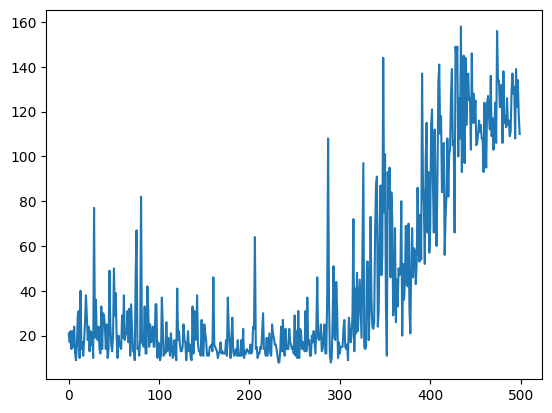

In [8]:
plt.plot(results_dqn)
plt.show()

## PPO

## Part 2

Proximal Policy Optimization (https://arxiv.org/pdf/1707.06347.pdf) is a type of policy gradient method. Instead of calculating Q-values, we train a network $\pi$ to optimize the probability of taking good actions directly, using states as inputs and actions as outputs. PPO also uses a value network $V$ that estimates state values in order to estimate the advantage $\hat{A}$.

Tuples of state, action distribution, action taken, and return $(s,\pi(s), a,\hat{R})$ are gathered for several rollouts. After training on this experience, these tuples are discarded and new experience is gathered.

Loss for the value network and the policy network are calculated according to the following formula:

$Loss=ValueLoss+PolicyLoss$

$ValueLoss=\frac{1}{N}\sum \bigg(\hat{R} - V(s) \bigg)^2 $

$PolicyLoss=-\frac{1}{N}\sum \min\bigg( \frac{\pi'(a|s)}{\pi(a|s)} \hat{A}, clip(\frac{\pi'(a|s)}{\pi(a|s)},1-\epsilon,1+\epsilon) \hat{A} \bigg) $

$\hat{R}_t = \sum_{i=t}^H \gamma^{i-t}r_i$

$\hat{A}_t=\hat{R}_t-V(s_t)$

Here, $\pi'(a|s)$ is the probability of taking an action given a state under the current policy and $\pi(a|s)$ is the probability of taking an action given a state under the policy used to gather data. In the loss function, $a$ is the action your agent actually took and is sampled from memory.

Additionally, the $clip$ function clips the value of the first argument according to the lower and upper bounds in the second and third arguments resectively.

Another important note: Your the calculation of your advantage $\hat{A}$ should not permit gradient flow from your policy loss calculation. In other words, make sure to call `.detach()` on your advantage.

### TODO

- Implement calculate return method
- Implement get action method
- Implement PPO learning algorithm

In [9]:
def calculate_return(memory, rollout, gamma):
    """
    Calculate discounted returns and append to memory.

    Args:
        memory (list): Existing memory list to append to.
        rollout (list): List of (state, action, action_dist, reward) tuples.
        gamma (float): Discount factor.

    Returns:
        list: Updated memory with (state, action, action_dist, return) tuples.
    """
    return_ = 0.0  # Initialize return as float32
    for state, action, action_dist, reward in reversed(rollout):
        return_ = float(reward) + gamma * return_
        return_ = np.float32(return_)  # Ensure return_ is float32
        memory.append((state, action, action_dist, return_))
    return memory


def get_action_ppo(network, state):
    """
    Sample action from the distribution obtained from the policy network.

    Args:
        network (PolicyNetwork): Policy Network.
        state (np.ndarray): Current state, shape (state_size,).

    Returns:
        int: Action sampled from the policy distribution.
        np.ndarray: Action probability distribution.
    """
    device = next(network.parameters()).device  # Get the device of the network
    state_tensor = torch.from_numpy(state).float().unsqueeze(0).to(device)  # shape (1, state_size)
    with torch.no_grad():
        logits = network(state_tensor)  # shape (1, action_size)
        action_probs = F.softmax(logits, dim=1)  # Convert logits to probabilities

    action_probs = action_probs.squeeze(0)  # shape (action_size)
    action_dist = action_probs.cpu().numpy()  # Convert to NumPy array for storage

    # Sample action from the probability distribution
    action = np.random.choice(len(action_dist), p=action_dist)
    return action, action_dist


def learn_ppo(optim, policy, value, memory_dataloader, epsilon, policy_epochs):
    """
    Implement PPO policy and value network updates.

    Args:
        optim (Adam): Optimizer for policy and value networks.
        policy (PolicyNetwork): Policy Network.
        value (ValueNetwork): Value Network.
        memory_dataloader (DataLoader): DataLoader with (state, action, action_dist, return) tuples.
        epsilon (float): Trust region parameter.
        policy_epochs (int): Number of training epochs.
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    for _ in range(policy_epochs):
        for state_batch, action_batch, old_action_probs_batch, return_batch in memory_dataloader:
            # Move tensors to the correct device
            state_batch = state_batch.to(device)
            action_batch = action_batch.to(device)
            old_action_probs_batch = old_action_probs_batch.to(device)
            return_batch = return_batch.to(device)

            # Verify tensor types
            assert state_batch.dtype == torch.float32, "state_batch is not float32"
            assert old_action_probs_batch.dtype == torch.float32, "old_action_probs_batch is not float32"
            assert return_batch.dtype == torch.float32, "return_batch is not float32"

            # Compute current action probabilities
            logits = policy(state_batch)  # shape (batch_size, action_size)
            action_probs = F.softmax(logits, dim=1)  # Convert logits to probabilities

            # Gather probabilities of taken actions
            current_action_probs = action_probs.gather(1, action_batch.unsqueeze(1)).squeeze(1)  # shape (batch_size)
            old_action_probs = old_action_probs_batch.gather(1, action_batch.unsqueeze(1)).squeeze(1)  # shape (batch_size)

            # Compute the ratio (pi_theta(a|s) / pi_theta_old(a|s))
            ratios = current_action_probs / (old_action_probs + 1e-8)

            # Compute value estimates and advantages
            values = value(state_batch).squeeze(1)  # shape (batch_size)
            advantages = (return_batch - values).detach()  # shape (batch_size)

            # Compute surrogate losses
            surr1 = ratios * advantages
            surr2 = torch.clamp(ratios, 1 - epsilon, 1 + epsilon) * advantages

            # Compute policy loss
            policy_loss = -torch.min(surr1, surr2).mean()

            # Compute value loss
            value_loss = F.mse_loss(values, return_batch)

            # Total loss
            loss = policy_loss + value_loss

            # Backpropagation and optimization step
            optim.zero_grad()
            loss.backward()
            optim.step()

### Modules

In [10]:
class RLDataset(Dataset):
    def __init__(self, memory):
        """
        Args:
            memory (list): List of tuples containing (state, action, action_dist, return).
        """
        self.memory = memory

    def __len__(self):
        return len(self.memory)

    def __getitem__(self, idx):
        state, action, action_dist, return_ = self.memory[idx]

        # Convert state to float32 tensor
        state = torch.from_numpy(state).float()

        # Convert action to int64 tensor
        action = torch.tensor(action).long()

        # Convert action_dist to float32 tensor
        action_dist = torch.from_numpy(action_dist).float()

        # Convert return_ to float32 tensor
        return_ = torch.tensor(return_, dtype=torch.float32)

        return state, action, action_dist, return_


# Policy Network
class PolicyNetwork(nn.Module):
  def __init__(self, state_size, action_size):
        super().__init__()
        hidden_size = 64
        self.action_size = action_size

        self.net = nn.Sequential(
            nn.Linear(state_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, action_size)
        )

  def forward(self, x):
    """Get policy from state

      Args:
          state (tensor): current state, size (batch x state_size)

      Returns:
          action_dist (tensor): probability distribution over actions (batch x action_size)
    """
    return self.net(x)


# Value Network
class ValueNetwork(nn.Module):
  def __init__(self, state_size):
    super().__init__()
    hidden_size = 64

    self.net = nn.Sequential(nn.Linear(state_size, hidden_size),
                             nn.ReLU(),
                             nn.Linear(hidden_size, hidden_size),
                             nn.ReLU(),
                             nn.Linear(hidden_size, hidden_size),
                             nn.ReLU(),
                             nn.Linear(hidden_size, 1))

  def forward(self, x):
    """Estimate value given state

      Args:
          state (tensor): current state, size (batch x state_size)

      Returns:
          value (tensor): estimated value, size (batch)
    """
    return self.net(x)

### Main

Epochs: 18 Reward: 200.0:  95%|█████████▌| 19/20 [03:09<00:12, 12.53s/it]/usr/local/lib/python3.10/dist-packages/gymnasium/wrappers/rendering.py:283: UserWarning: WARN: Overwriting existing videos at /content/video folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


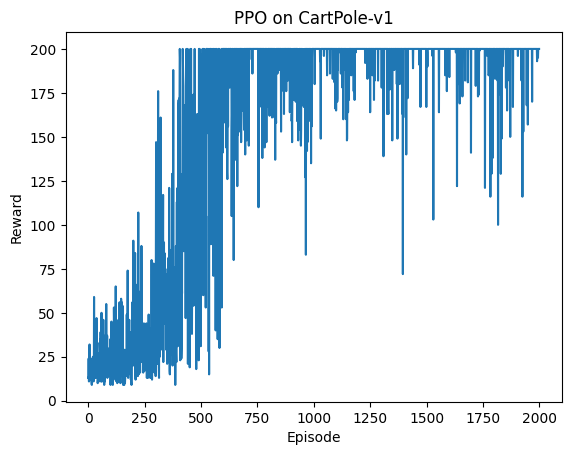

In [11]:
def ppo_main():
    # Hyper parameters
    lr = 1e-3
    epochs = 20
    env_samples = 100
    gamma = 0.9
    batch_size = 256
    epsilon = 0.2
    policy_epochs = 5

    # Init environment
    state_size = 4
    action_size = 2
    env = gym.make('CartPole-v1', render_mode="rgb_array")

    # Init networks
    policy_network = PolicyNetwork(state_size, action_size).cuda()
    value_network = ValueNetwork(state_size).cuda()

    # Init optimizer
    optim = torch.optim.Adam(chain(policy_network.parameters(), value_network.parameters()), lr=lr)

    # Start main loop
    results_ppo = []
    loop = tqdm(total=epochs, position=0, leave=False)
    for epoch in range(epochs):
        last_epoch = (epoch + 1 == epochs)
        # Record only last epoch
        if last_epoch:
            env = wrap_env(env)

        memory = []  # Reset memory every epoch
        rewards = []  # Calculate average episodic reward per epoch

        # Begin experience loop
        for episode in range(env_samples):
            # Reset environment
            state, _ = env.reset()
            done = False
            rollout = []
            cum_reward = 0  # Track cumulative reward

            # Begin episode
            while not done and cum_reward < 200:  # End after 200 steps
                # Get action
                action, action_dist = get_action_ppo(policy_network, state)

                # Take step
                next_state, reward, terminated, truncated, _ = env.step(action)
                done = terminated or truncated
                # env.render()

                # Store step
                rollout.append((state, action, action_dist, reward))

                cum_reward += reward
                state = next_state  # Set current state

            # Calculate returns and add episode to memory
            memory = calculate_return(memory, rollout, gamma)

            rewards.append(cum_reward)
        env.close()

        # Train
        dataset = RLDataset(memory)
        loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
        learn_ppo(optim, policy_network, value_network, loader, epsilon, policy_epochs)

        # Print results
        results_ppo.extend(rewards)  # Store rewards for this epoch
        loop.update(1)
        loop.set_description("Epochs: {} Reward: {}".format(epoch, results_ppo[-1]))

    return results_ppo

results_ppo = ppo_main()
show_video()

# Plot the learning curve
plt.plot(results_ppo)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('PPO on CartPole-v1')
plt.show()

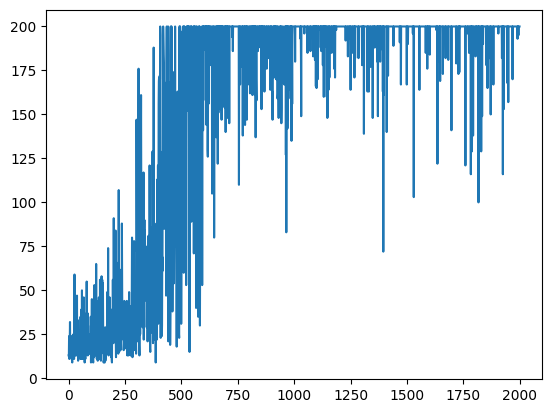

In [12]:
plt.plot(results_ppo)
plt.show()